In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale = 1.56)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

In [8]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = train.append(test)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [57]:
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

import warnings
warnings.filterwarnings("ignore")

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


# Start from two feature : Sex & Pclass

## Sex

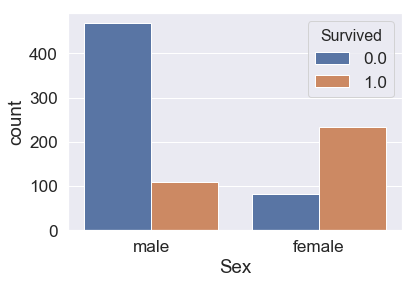

In [13]:
sns.countplot(data['Sex'],hue=data['Survived'])


In [16]:
data[['Sex','Survived']].groupby(['Sex'], as_index=False).mean().round(3)

,Sex,Survived
0,female,0.742
1,male,0.189


### About 75% female survived while only 19% male survived

## Pclass 

sns.countplot(data['Pclass'],hue=data['Survived'])

In [19]:
data[['Pclass','Survived']].groupby(data['Pclass'],as_index=False).mean().round(3)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


# Data Transfered:

In [20]:
#Convert Sex:
data['Sex_Code'] = data['Sex'].map({'female':0,'male':1}).astype('int') 

In [23]:
#Divide Train and Test
train = data[:len(train)]
test = data[len(train):]

In [26]:
#Set X and Y(survived)
X = train.drop(labels=['Survived','PassengerId'],axis=1)
Y = train['Survived']

# Build a RandomForest model

In [29]:
Base = ['Sex_Code','Pclass']
Base_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_model.fit(X[Base],Y)
print('Base oob score : %.5f' %(Base_model.oob_score_))

Base oob score : 0.73176


### Now, the model only use sex and Pclass as feature to predict survived, and the accuracy rate is 0.731 (submit to Kaggle will get accuracy about 0.76).

### To improve the accuracy rate, we have to consider more feature and one by one to see whether the rate is improve or not, to find the best model.

Text(0.5, 1.0, 'Log_Fare & Pclass vs Survived')

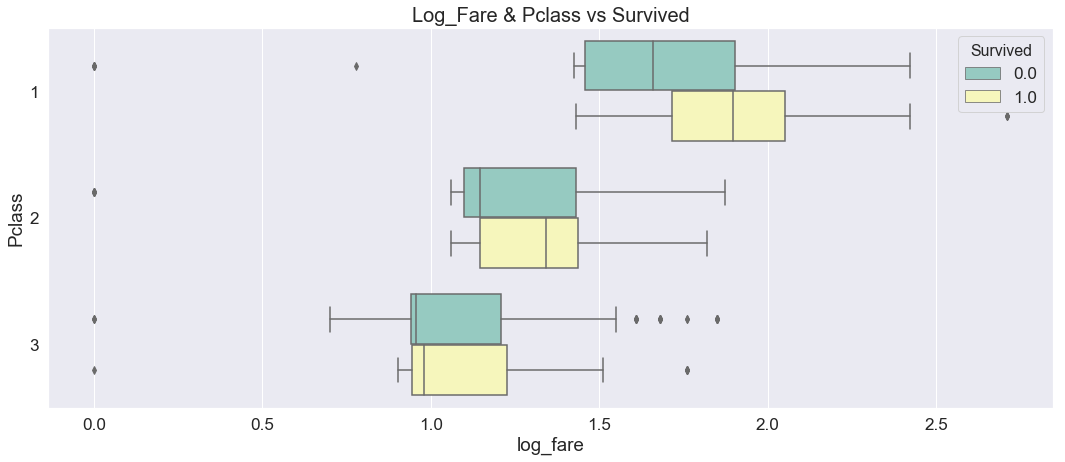

In [46]:
#transfer x to log x for visualization
fig, ax = plt.subplots(figsize=(18,7))
data['log_fare'] = (data['Fare']+1).map(lambda x : np.log10(x) if x >0 else 0)
sns.boxplot(y='Pclass',x ='log_fare',hue='Survived',data=data,orient='h',ax=ax,palette='Set3')
ax.set_title('Log_Fare & Pclass vs Survived',fontsize = 20)

In [43]:
pd.pivot_table(data,values=['Fare'],index=['Pclass'],columns=['Survived'],aggfunc='median').round(3)

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

### By the plot and the table, we can see the survived passenger indeed paid higher fare, so we can test this feature

### But how many section do we need to seperate?

In [50]:
# First, fill na by median(because only one na)
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [55]:
data['FareBin_4']= pd.qcut(data['Fare'],4)
data['FareBin_5']= pd.qcut(data['Fare'],5)
data['FareBin_6']= pd.qcut(data['Fare'],6)

label = LabelEncoder()
data['FareBinCode_4'] = label.fit_transform(data['FareBin_4'])
data['FareBinCode_5'] = label.fit_transform(data['FareBin_5'])
data['FareBinCode_6'] = label.fit_transform(data['FareBin_6'])

data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_Code,log_fare,FareBin_4,FareBin_5,FareBin_6,FareBinCode_4,FareBinCode_5,FareBinCode_6
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,1,0.975813,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,1.723148,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,1,1.343901,"(14.454, 31.275]","(10.5, 21.558]","(14.454, 26.0]",2,2,3
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,0,1.083979,"(7.896, 14.454]","(10.5, 21.558]","(8.662, 14.454]",1,2,2
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,0,1.492352,"(14.454, 31.275]","(21.558, 41.579]","(26.0, 53.1]",2,3,4


In [58]:
#cross tab
df_4 = pd.crosstab(data['FareBinCode_4'],data['Pclass'])
df_5 = pd.crosstab(data['FareBinCode_5'],data['Pclass'])
df_6 = pd.crosstab(data['FareBinCode_6'],data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

Pclass,1,2,3
FareBinCode_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBinCode_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


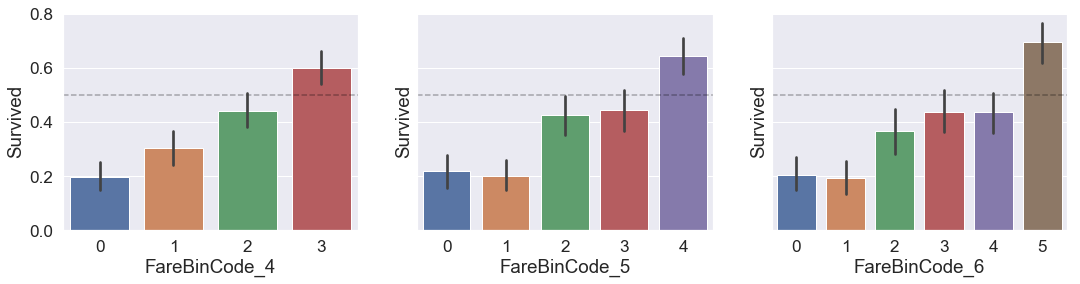

In [60]:
#plots
fig, [ax1,ax2,ax3] = plt.subplots(1,3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1,ax2,ax3]:
    axi.axhline(0.5,linestyle='dashed',c='black',alpha=.3)
g1 = sns.factorplot(x='FareBinCode_4',y='Survived',data=data ,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBinCode_5',y='Survived',data=data ,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBinCode_6',y='Survived',data=data ,kind='bar',ax=ax3)
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [63]:
#split into test and train
train = data[:len(train)]
test = data[len(train):]

#X and Y
X = train.drop(labels=['Survived','PassengerId'],axis=1)
Y = train['Survived']

X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_Code', 'log_fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBinCode_4', 'FareBinCode_5', 'FareBinCode_6'],
      dtype='object')

In [65]:
compare=['Sex_Code','Pclass','FareBinCode_4', 'FareBinCode_5', 'FareBinCode_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare],Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.66981614 77.33398593 79.23663602 79.46390875 80.14308819]


In [66]:
score_b4,score_b5,score_b6 = [],[],[]
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector.fit(X[compare], Y)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

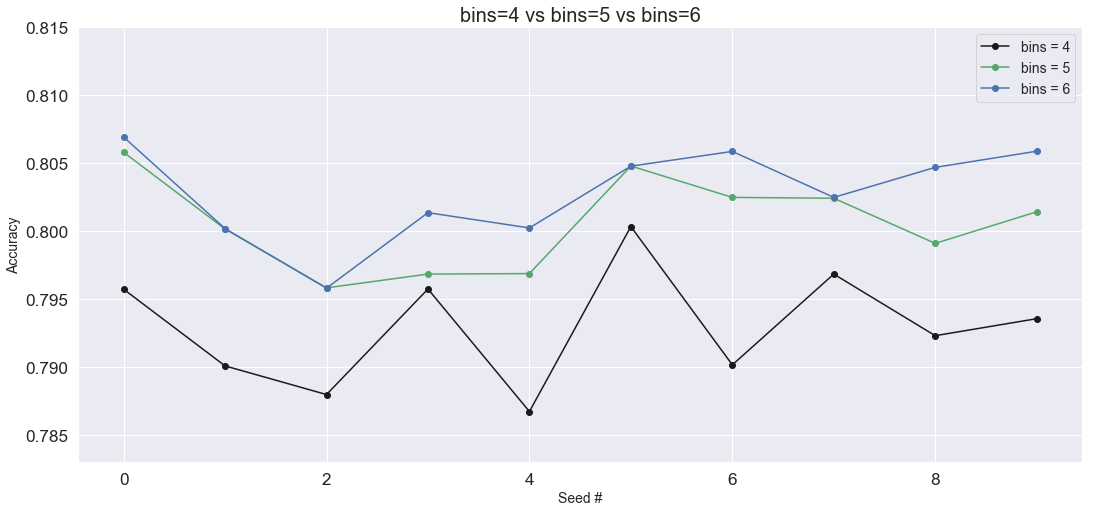

In [70]:
score_list = [score_b4,score_b5,score_b6]
for item in score_list:
    item = np.array(item*100)

fig,ax = plt.subplots(figsize=(18,8))
ax.plot(range(seeds), score_b4,'-ok',label = 'bins = 4')
ax.plot(range(seeds), score_b5,'-og',label = 'bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label = 'bins = 6')
ax.set_xlabel('Seed #',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_ylim(0.783,0.815)
ax.set_title('bins=4 vs bins=5 vs bins=6',fontsize=20)
plt.legend(fontsize=14,loc='upper right')

In [71]:
b4,b5,b6 = ['Sex_Code','Pclass','FareBinCode_4'],['Sex_Code','Pclass','FareBinCode_5'],['Sex_Code','Pclass','FareBinCode_6']
b4_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_model.fit(X[b4],Y)
b5_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_model.fit(X[b5],Y)
b6_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_model.fit(X[b6],Y)

print('b4 oob_score_ : %5f' %(b4_model.oob_score_))
print('b5 oob_score_ : %5f' %(b5_model.oob_score_))
print('b6 oob_score_ : %5f' %(b6_model.oob_score_))

b4 oob_score_ : 0.805836
b5 oob_score_ : 0.810325
b6 oob_score_ : 0.801347


### Now we can see that seperating in 5 section gets the highest accuracy rate.

# Connection:

### Connection means that passengers have same ticket means that they are probably family or friends, and these people who have connection may survive or die together

In [72]:
train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [73]:
# Family size
data['FamilySize'] = data['SibSp'] + data['Parch'] +1

In [84]:
deplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk,'Fare']
    if tem.count()>1:
        deplicate_ticket.append(data.loc[data.Ticket==tk,['Name','Ticket','Fare','Cabin','FamilySize','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,FamilySize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


### By the table, we can find the connection between each group memeber

### If someone `s family size is 1 but he or she is in a group , then we consider that group as Friend; otherwise, we consider as family

In [92]:
fri = deplicate_ticket.loc[(deplicate_ticket.FamilySize == 1) & (deplicate_ticket.Survived.notnull())].head(7)
fami = deplicate_ticket.loc[(deplicate_ticket.FamilySize > 1) & (deplicate_ticket.Survived.notnull())].head(7)

display(fri,fami)
print('People keep the same ticket : %.0f' % len(deplicate_ticket))
print('Friends : %.0f' % len(deplicate_ticket.loc[(deplicate_ticket.FamilySize == 1)]))
print('Family : %.0f' % len(deplicate_ticket.loc[(deplicate_ticket.FamilySize > 1)]))

,Name,Ticket,Fare,Cabin,FamilySize,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,FamilySize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


People keep the same ticket : 596
Friends : 127
Family : 469


In [138]:
# If there is one person survived in a group ==> connection_survived = 1
# If there is no peoeple survived in a group ==> connection_survived = 0
# Nan ==> connection_survived = 0.5

data['Connection_Survived'] = 0.5
for ticketNO, grp in data.groupby('Ticket'):
      if(len(grp) > 1):
        for ind, row in grp.iterrows():
            smax = grp.drop(ind)['Survived'].max()
            smin = grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if(smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connection_Survived'] = 1
            elif(smin == 0.0):
                data.loc[data['PassengerId'] == passID,'Connection_Survived'] = 0

print('People keep the same ticket: %.0f' % len(deplicate_ticket))
print('People have connected information: %.0f' % data[data['Connection_Survived'] != 0.5].shape[0])
data.groupby('Connection_Survived')[['Survived']].mean().round(3)

People keep the same ticket: 596
People have connected information: 496


,Survived
Connection_Survived,
0.0,0.225
0.5,0.298
1.0,0.728


In [145]:
data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Sex_Code,log_fare,FareBin_4,FareBin_5,FareBin_6,FareBinCode_4,FareBinCode_5,FareBinCode_6,FamilySize,Connection_Survived
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,1,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0,2,0.5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5,2,0.5
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,0,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,0,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4,2,0.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,1,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,...,1,0.975813,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,...,1,1.723148,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4,1,0.5
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,...,1,1.343901,"(14.454, 31.275]","(10.5, 21.558]","(14.454, 26.0]",2,2,3,5,0.0
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,...,0,1.083979,"(7.896, 14.454]","(10.5, 21.558]","(8.662, 14.454]",1,2,2,3,1.0
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,...,0,1.492352,"(14.454, 31.275]","(21.558, 41.579]","(26.0, 53.1]",2,3,4,2,0.0


In [144]:
train = data[:len(train)]
test = data[len(train):]

X = train.drop(labels=['Survived','PassengerId'],axis=1)
Y = train['Survived']

In [148]:
connect = ['Sex_Code','Pclass','FareBinCode_5','Connection_Survived']
connect_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)

connect_model.fit(X[connect],Y)
print('oob score: %.5f' % (connect_model.oob_score_))

oob score: 0.82379


In [149]:
#Submit
X_Submit = test.drop(labels=['PassengerId'],axis=1)

connect_pred = connect_model.predict(X_Submit[connect])

submit = pd.DataFrame({'PassengerId':test['PassengerId'],"Survived":connect_pred.astype('int')})

submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# Age: 

### Compare to Fare, Age has many null value, so we observe the null value distribution first.

Sex,female,male,All
HasAge,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


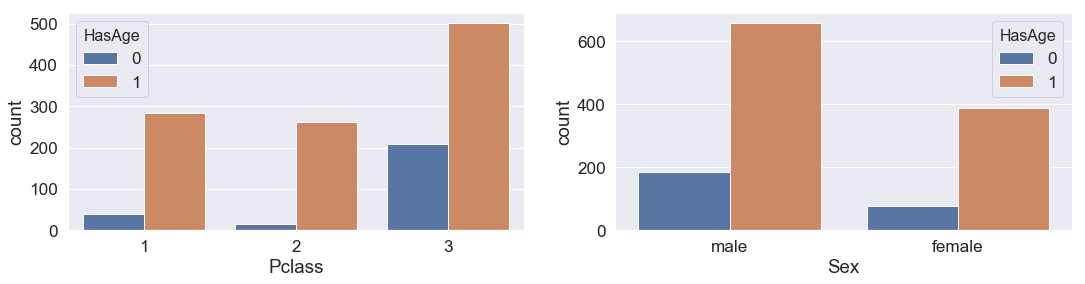

In [153]:
data['HasAge'] = data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figwidth(18)
ax1 = sns.countplot(data['Pclass'],hue=data['HasAge'],ax=ax1)
ax2 = sns.countplot(data['Sex'],hue=data['HasAge'],ax=ax2)
pd.crosstab(data['HasAge'],data['Sex'],margins=True).round(3)

## From the left plot, we can find out that most of null value are third class, if Age really influnce the survived rate, these null value will make our prediction wrong.

## So, first, we can observer whether Age influence survived rate of First and Second class.

Text(0.5, 1.0, 'Age vs Survived Rate in Pclass=1 and 2')

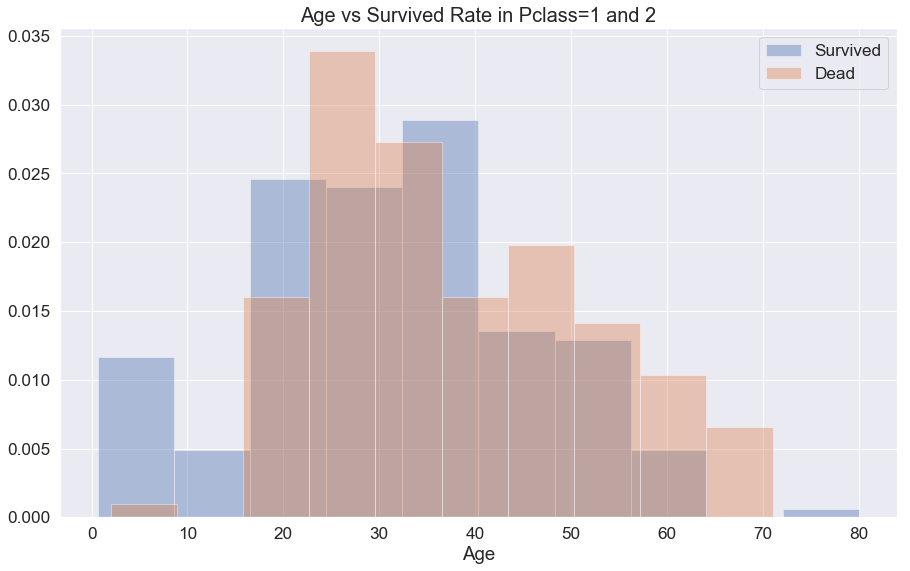

In [155]:
HasAge_P12_Survived = ((data.HasAge==1) & (data.Pclass !=3) & (data.Survived == 1))
HasAge_P12_Dead = ((data.HasAge==1) & (data.Pclass !=3) & (data.Survived == 0))

fig,ax = plt.subplots(figsize=(15,9))
ax = sns.distplot(data.loc[HasAge_P12_Survived,'Age'],kde=False,bins=10,norm_hist=True,label='Survived')
ax = sns.distplot(data.loc[HasAge_P12_Dead,'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived Rate in Pclass=1 and 2',fontsize=20)

### From this plot, we can see that people who younger than 16 have higher survive rate. When older than 16, Age dont have strong influence in Pclass =1 and 2

In [157]:
# extracted title using name
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
data['Title'] = data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
data['Title'] = data['Title'].replace(['Lady'],'Mrs')
data['Title'] = data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [167]:
Ti_pred = data.groupby('Title')['Age'].median().values
data['Ti_age'] = data['Age']

for i in range(0,5):
    data.loc[(data.Age.isnull()) & (data.Title == i),'Ti_age'] = Ti_pred[i]
data['Ti_age'] = data['Ti_age'].astype('int')
data['Ti_minor'] = ((data['Ti_age']) < 16.0) *1

In [169]:
train = data[:len(train)]
test = data[len(train):]

X = train.drop(labels=['Survived','PassengerId'],axis=1)
Y = train['Survived']

In [170]:
minor = ['Sex_Code','Pclass','FareBinCode_5','Connection_Survived','Ti_minor']
minor_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)

minor_model.fit(X[minor],Y)
print('oob score: %.5f' % (minor_model.oob_score_))

oob score: 0.84624


# Submit

In [172]:
X_Submit = test.drop(labels=['PassengerId'],axis=1)

minor_pred = minor_model.predict(X_Submit[minor])

submit = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':minor_pred.astype('int')})

submit.to_csv('Second_Submit.csv',index=False)

In [174]:
# https://medium.com/@yulongtsai/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f